In [100]:
from voxcell import VoxelData, RegionMap
import numpy
import h5py
import pandas

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from joblib import Parallel, delayed, parallel_config


# Paths to data.
# Make sure that all voxel datasets have the same resolution.

# Part of AIBS CCFv3. Region hierarchy.
# http://api.brain-map.org/api/v2/structure_graph_download/1.json
fn_hier = "1.json"
# Part of AIBS CCFv3. Region annotations.
# https://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2022/annotation_10.nrrd
fn_ann = "annotation_10.nrrd"
# Part of AIBS CCFv3. Flatmap paths.
# https://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/dorsal_flatmap_paths_10.h5
fn_aibs = "dorsal_flatmap_paths_10.h5"

# Our flatmaps.
npix_flat = 256
fn_shaped = "flatmap_authalic_shaped_256.nrrd"
fn_square = "flatmap_authalic_square_256.nrrd"

labels = ["AIBS", "Square", "AIBS-shaped"]

In [3]:
# Load annotations and region hierarchy
ann = VoxelData.load_nrrd(fn_ann)
rmap = RegionMap.load_json(fn_hier)

Next, we load the region hierarchy and take out its lowest level.

That is, because the lowest level in cortical regions indicates individual layers of a given region. Here, we are not interested in layers, only the regions themselves. So we remove that lowest level from the hierarchy and annotations, and re-label the regions in Isocortex sequentially.

In [4]:
# Get Isocortex region IDs in atlas
isoctx_ids = list(rmap.find('Isocortex', attr='acronym', with_descendants=True))
mask = numpy.isin(ann.raw, isoctx_ids)
used_ids = numpy.unique(ann.raw[mask])

# Label voxels with next-to-last region in hierarchy, re-indexed from 1 to 43
reg_acro = numpy.unique([rmap.get(x, attr='acronym', with_ascendants=True)[1] for x in used_ids])
reg_acro_map = {x:i + 1 for i, x in enumerate(reg_acro)}
used_ids_map = {x:reg_acro_map[rmap.get(x, attr='acronym', with_ascendants=True)[1]] for x in used_ids}
ann.raw[mask] = [used_ids_map[x] for x in ann.raw[mask]]
ann.raw[~mask] = 0
del mask

In [5]:
tgt_ids = reg_acro_map.values()
tgt_acronyms = reg_acro_map.keys()
reg_acro_map

{'ACAd': 1,
 'ACAv': 2,
 'AId': 3,
 'AIp': 4,
 'AIv': 5,
 'AUDd': 6,
 'AUDp': 7,
 'AUDpo': 8,
 'AUDv': 9,
 'ECT': 10,
 'FRP': 11,
 'GU': 12,
 'ILA': 13,
 'MOp': 14,
 'MOs': 15,
 'ORBl': 16,
 'ORBm': 17,
 'ORBvl': 18,
 'PERI': 19,
 'PL': 20,
 'RSPagl': 21,
 'RSPd': 22,
 'RSPv': 23,
 'SSp-bfd': 24,
 'SSp-ll': 25,
 'SSp-m': 26,
 'SSp-n': 27,
 'SSp-tr': 28,
 'SSp-ul': 29,
 'SSp-un': 30,
 'SSs': 31,
 'TEa': 32,
 'VISC': 33,
 'VISa': 34,
 'VISal': 35,
 'VISam': 36,
 'VISl': 37,
 'VISli': 38,
 'VISp': 39,
 'VISpl': 40,
 'VISpm': 41,
 'VISpor': 42,
 'VISrl': 43}

# Step 1:
Convert all flatmaps to pandas.DataFrame with the same representation.
Columns: "x", "y", "z", "pxl_x", "pxl_y", "idx", "ann". Each row corresponds to a mapped voxel.
There may be multiple rows for a given voxel, if it is mapped to multiple pixels.

"x", "y", "z" are the indices of a voxel in the 3D voxel map.

"pxl_x", "pxl_y" are the coordinates of the pixel a voxel is mapped to.

"idx" is the 1D index of a voxel, i.e. its index after flattening the 3d voxel map (numpy.flatten).

"ann" is the region annotation for that voxel.

## For nrrd-based flatmaps

In [6]:
def nrrd_flatmap_to_pandas(fm, ann):
    msk = fm.raw[:, :, :, 0] > -1
    vox = numpy.nonzero(msk)
    pd_fm = pandas.DataFrame(
        {
            "x": vox[0],
            "y": vox[1],
            "z": vox[2],
            "pxl_x": fm.raw[:, :, :, 1][msk].flatten(),
            "pxl_y": fm.raw[:, :, :, 0][msk].flatten(),
            "idx": numpy.flatnonzero(msk),
            "ann": ann.raw[vox]
        }
    )
    return pd_fm

## For path-based flatmaps

In [7]:
def paths_flatmap_to_pandas(pxl_lo, fm_paths, ann):
    # From pixel coordinates to path ids
    pxl_y, pxl_x = numpy.meshgrid(numpy.arange(pxl_lo.shape[1]), numpy.arange(pxl_lo.shape[0]))
    path2pxl = pandas.DataFrame({"pxl_x": pxl_x.flatten(), "pxl_y": pxl_y.flatten()},
                                index=pandas.Index(pxl_lo.flatten(), name="path"))
    # A path id < 0 indicates no path, i.e. no voxels mapped to that pixel
    # At 10 um, path 0 is indistinguishable from background...
    path2pxl = path2pxl[path2pxl.index > 0]

    # From path ids to linear voxel ids
    #  fm_path: Index along the first dimension corresponds to the path id.
    #  Values in a row indicate linear voxel indices + 1. Rows are padded with "0" for equal length.
    _, path_id = numpy.meshgrid(numpy.arange(fm_paths.shape[1]), numpy.arange(fm_paths.shape[0]))
    path_id2idx = pandas.Series(fm_paths.flatten(), name="idx", index=pandas.Index(path_id.flatten(), name="path")) - 1
    # Remove padding and skip path 0
    path_id2idx = path_id2idx[(path_id2idx > 0) & (path_id2idx.index > 0)]

    # Put it all together: First, columns "pxl_x", "pxl_y", "idx".
    pd_fm = pandas.concat([path2pxl.loc[path_id2idx.index], path_id2idx], axis=1).reset_index(drop=True)
    # Next "x", "y", "z"
    w = numpy.unravel_index(pd_fm["idx"], ann.shape)
    vox = pandas.DataFrame({"x":w[0], "y":w[1], "z":w[2]})
    pd_fm = pandas.concat([vox, pd_fm], axis=1)
    # Finally: "ann"
    pd_fm["ann"] = ann.raw[w]
    return pd_fm

### Read and convert flatmaps

In [8]:
# Square border
fm_square = VoxelData.load_nrrd(fn_square)
pd_fm_square = nrrd_flatmap_to_pandas(fm_square, ann)
del fm_square

In [9]:
pd_fm_square

,x,y,z,pxl_x,pxl_y,idx,ann
0,181,254,495,73,224,165362055,11
1,181,254,496,73,224,165362056,11
2,181,254,497,73,224,165362057,11
3,181,254,498,73,225,165362058,11
4,181,254,499,73,225,165362059,11
...,...,...,...,...,...,...,...
123465445,1037,232,913,249,509,946009393,40
123465446,1037,232,914,249,510,946009394,40
123465447,1037,232,915,249,510,946009395,40
123465448,1037,233,252,255,4,946009872,40


In [10]:
# AIBS-shape border
fm_shaped = VoxelData.load_nrrd(fn_shaped)
pd_fm_shaped = nrrd_flatmap_to_pandas(fm_shaped, ann)
del fm_shaped

In [11]:
pd_fm_shaped

,x,y,z,pxl_x,pxl_y,idx,ann
0,181,254,495,53,169,165362055,11
1,181,254,496,53,169,165362056,11
2,181,254,497,53,169,165362057,11
3,181,254,498,53,169,165362058,11
4,181,254,499,53,169,165362059,11
...,...,...,...,...,...,...,...
123465445,1037,232,913,249,387,946009393,40
123465446,1037,232,914,249,387,946009394,40
123465447,1037,232,915,249,388,946009395,40
123465448,1037,233,252,250,130,946009872,40


In [12]:
# AIBS reference flatmap
with h5py.File(fn_aibs, "r") as h5:
    pxl_lo = h5["view lookup"][:]
    fm_paths = h5["paths"][:]
npix_aibs = pxl_lo.shape[0]
pd_fm_aibs = paths_flatmap_to_pandas(pxl_lo, fm_paths, ann)
# Remove voxels not in Isocortex
pd_fm_aibs = pd_fm_aibs.loc[pd_fm_aibs["ann"] > 0]

In [13]:
pd_fm_aibs

,x,y,z,pxl_x,pxl_y,idx,ann
1,861,455,64,819,129,785750764,19
2,861,455,65,819,129,785750765,19
3,861,455,66,819,129,785750766,19
4,861,455,67,819,129,785750767,19
6,862,455,64,820,129,786662764,19
...,...,...,...,...,...,...,...
222368329,404,352,613,474,1471,368849893,2
222368330,404,352,614,474,1471,368849894,2
222368331,405,352,615,474,1471,369761895,2
222368332,405,352,615,474,1471,369761895,2


In [ ]:
# Only consider voxels that are flattened in the reference (common domain)
mask = numpy.isin(pd_fm_square["idx"], pd_fm_aibs["idx"])
pd_fm_square = pd_fm_square.loc[mask]

mask = numpy.isin(pd_fm_shaped["idx"], pd_fm_aibs["idx"])
pd_fm_shaped = pd_fm_shaped.loc[mask]

# Note: voxels can be assigned to multiple pixels in the AIBS flatmap!

In [15]:
pd_flatmaps = [pd_fm_aibs, pd_fm_square, pd_fm_shaped]

## Visualize the coordinates of one flatmap in another
It returns for each pixel in one flatmap the mean pixel value (x or y) in the other flatmap

In [16]:
def visualize_flatmap_in_other_flatmap(fm_use, fm_show, prop_to_show,
                                       props_to_use=["pxl_x", "pxl_y"], prop_to_match="idx"):
    if fm_use is fm_show:
        fm_use = fm_use.set_index(prop_to_match)
    else:
        mask = numpy.isin(fm_use[prop_to_match], fm_show[prop_to_match])
        fm_use = fm_use.loc[mask].set_index(prop_to_match)
    
    viz = fm_show.groupby(prop_to_match)[prop_to_show].mean()
    viz = viz[fm_use.index]
    viz.name = "viz"
    M = pandas.concat([fm_use, viz], axis=1).groupby(props_to_use)["viz"].mean()
    return M.unstack(props_to_use[1])

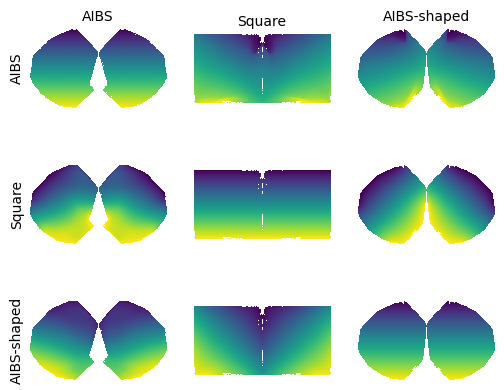

In [18]:
fig = plt.figure(figsize=(6, 5))

for i, pd_fm_1 in enumerate(pd_flatmaps):
    for j, pd_fm_2 in enumerate(pd_flatmaps):
        ax = fig.add_subplot(3, 3, 3 * i + j + 1)
        im = visualize_flatmap_in_other_flatmap(pd_fm_2, pd_fm_1, "pxl_x")
        ax.imshow(im, interpolation='nearest')  # with interior NaNs (holes), interpolation screws up the image
        # ax.set_ylabel("pixel: y")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_frame_on(False)
        if i == 0: ax.set_title(labels[j], fontsize=10)
        if j == 0: ax.set_ylabel(labels[i])

fig.savefig("comparing_flatmap_coordinates_10um.pdf")

## Comparing how region annotations are represented 

In [19]:
# For each pixel we use the region annotation that has the most voxels associated with the pixel
def get_mode(v_in):
    return v_in.value_counts().index[0]

Maibs = pd_fm_aibs.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_mode)
Msquare = pd_fm_square.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_mode)
Mshaped = pd_fm_shaped.groupby(["pxl_x", "pxl_y"])["ann"].apply(get_mode)

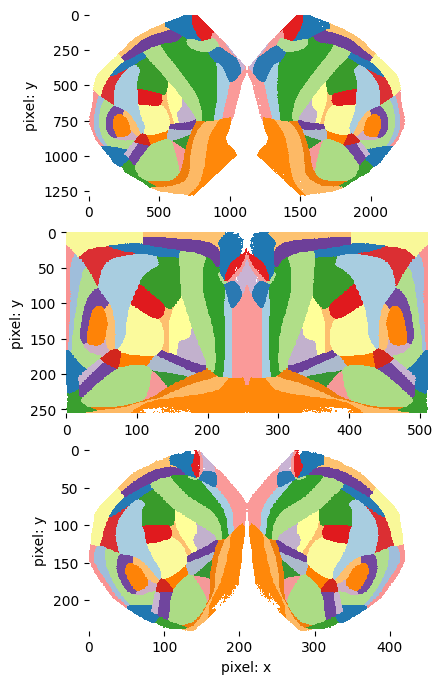

In [21]:
fig = plt.figure(figsize=(5, 8))
cmap = ['#a6cee3','#fb9a99','#6a3d9a','#ffff99','#fdbf6f','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#a6cee3',
        '#b2df8a','#1f78b4','#cab2d6','#b2df8a','#33a02c','#1f78b4','#fb9a99','#e31a1c','#fb9a99','#1f78b4',
        '#ff7f00','#fdbf6f','#ff7f00','#ffff99','#cab2d6','#33a02c','#e31a1c','#6a3d9a','#ffff99','#fdbf6f',
        '#a6cee3','#b2df8a','#e31a1c','#a6cee3','#e31a1c','#33a02c','#6a3d9a','#cab2d6','#b2df8a','#33a02c',
        '#fb9a99','#1f78b4','#ff7f00']
cmap = [tuple(int(h.lstrip('#')[i:i+2], 16) / 255 for i in (0, 2, 4)) for h in cmap]
cmap = LinearSegmentedColormap.from_list("isocortex", cmap)

ax = fig.add_subplot(3, 1, 1)
ax.imshow(Maibs.unstack("pxl_y"), cmap=cmap, interpolation="nearest")
ax.set_ylabel("pixel: y")
ax.set_frame_on(False)

ax = fig.add_subplot(3, 1, 2)
ax.imshow(Msquare.unstack("pxl_y"), cmap=cmap, interpolation="nearest")
ax.set_ylabel("pixel: y")
ax.set_frame_on(False)

ax = fig.add_subplot(3, 1, 3)
ax.imshow(Mshaped.unstack("pxl_y"), cmap=cmap, interpolation="nearest")
ax.set_ylabel("pixel: y")
ax.set_xlabel("pixel: x")
ax.set_frame_on(False)

fig.savefig("comparing_region_annotations_10um.pdf")

# How well do the flatmaps represent the actual geometry?

First, how well are the sizes of regions represented by their sizes in each flatmap?

AIBS           0.891921
Square         0.850195
AIBS-shaped    0.856179
voxels         1.000000
Name: voxels, dtype: float64


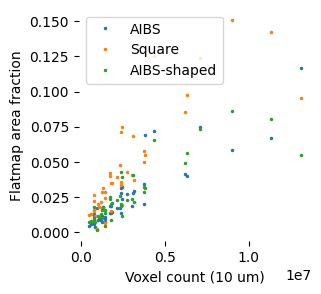

In [22]:
# For each region id: How many pixels are associated with it in each of the flat maps?
# We account for different pixel sizes by normalizing by total number of pixels
ann_cmp = pandas.concat([Maibs.value_counts().sort_index() / npix_aibs ** 2,
                         Msquare.value_counts().sort_index() / npix_flat ** 2,
                         Mshaped.value_counts().sort_index() / npix_flat ** 2 ],
                         axis=1, keys=labels)
# Adjust by pixel size (how many in 
# For comparison: How many voxels are associated with each region?
ann_cmp["voxels"] = [(ann.raw == _i).sum() for _i in ann_cmp.index]

fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

for lab in labels:
    ax.plot(ann_cmp["voxels"], ann_cmp[lab], '.', ms=3, label=lab)
ax.set_xlabel("Voxel count (10 um)")
ax.set_ylabel("Flatmap area fraction")
ax.set_frame_on(False)

plt.legend()

print(ann_cmp.corr()["voxels"])
fig.savefig("comparing_area_vs_voxel_counts.pdf")

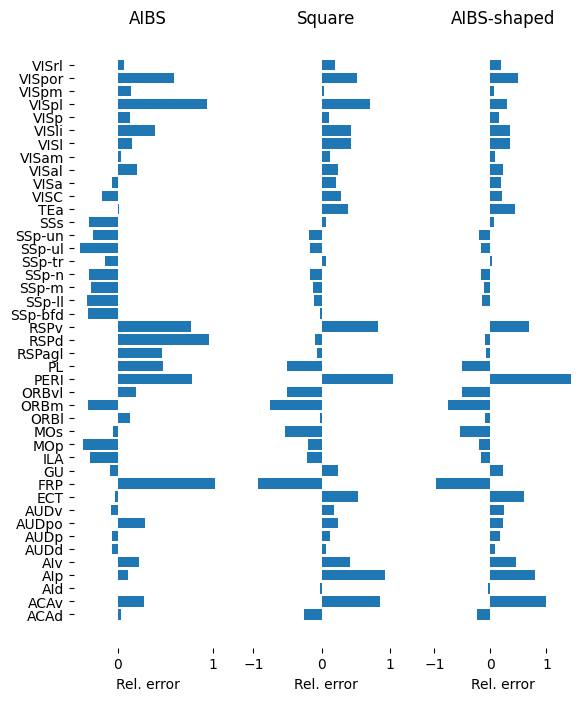

In [23]:
def region_size_prediction_error(df, col_x, col_y):
    a, b = numpy.polyfit(df[col_x], df[col_y], 1)
    err = a * df[col_x] + b - ann_cmp[col_y]
    rel_err = err / ann_cmp[col_y]
    rel_err.name = col_x
    return rel_err

rel_err = pandas.concat([
    region_size_prediction_error(ann_cmp, labels[0], "voxels"),
    region_size_prediction_error(ann_cmp, labels[1], "voxels"),
    region_size_prediction_error(ann_cmp, labels[2], "voxels")
], axis=1)

fig = plt.figure(figsize=(6.5, 8))

ax = fig.add_subplot(1, 3, 1)
ax.barh(range(len(rel_err)), rel_err[labels[0]])
ax.set_frame_on(False)
ax.set_yticks(range(len(rel_err)))
_ = ax.set_yticklabels(tgt_acronyms)
ax.set_title(labels[0])
ax.set_xlabel("Rel. error")

ax = fig.add_subplot(1, 3, 2)
ax.barh(range(len(rel_err)), rel_err[labels[1]])
ax.set_frame_on(False)
ax.set_yticks([])
ax.set_title(labels[1])
ax.set_xlabel("Rel. error")

ax = fig.add_subplot(1, 3, 3)
ax.barh(range(len(rel_err)), rel_err[labels[2]])
ax.set_frame_on(False)
ax.set_yticks([])
ax.set_title(labels[2])
ax.set_xlabel("Rel. error")

fig.savefig("comparing_area_vs_voxel_count_errors.pdf")

Second: Neighborhood relations: How well are the sizes of the borders between regions represented?

In [26]:
# For each pair of region ids i and j: How many neighboring pixels / voxels are there, 
# such that one has value i and the other value j?
# We consider direct neighbors, not diagonal ones. That is: four neighbors in the 2d case,
# 6 neighbors in the 3d case.
def get_region_border(annotations, rid):
    main_mask = annotations == rid
    if main_mask.ndim == 3:
        neighbor_ann = numpy.hstack([
            annotations[:, :, 1:][main_mask[:, :, :-1]],
            annotations[:, :, :-1][main_mask[:, :, 1:]],
            annotations[:, 1:, :][main_mask[:, :-1, :]],
            annotations[:, :-1, :][main_mask[:, 1:, :]],
            annotations[1:, :, :][main_mask[:-1, :, :]],
            annotations[:-1, :, :][main_mask[1:, :, :]]
        ])
    elif main_mask.ndim == 2:
        neighbor_ann = numpy.hstack([
            annotations[:, 1:][main_mask[:, :-1]],
            annotations[:, :-1][main_mask[:, 1:]],
            annotations[1:, :][main_mask[:-1, :]],
            annotations[:-1, :][main_mask[1:, :]]
        ])
    else: raise ValueError()
    return pandas.Series(neighbor_ann, name="neighbors").value_counts().drop(rid)

def get_border_counts(annotations, tgt_ids, n_jobs=11):
    with parallel_config(backend='threading', n_jobs=n_jobs):
        border_counts = Parallel()(delayed(get_region_border)(annotations, rid) for rid in tgt_ids)
    border_counts = pandas.concat(border_counts, axis=0, keys=tgt_ids, names=["region"])
    border_counts_mat = border_counts.unstack("neighbors", fill_value=0)[tgt_ids]
    return border_counts_mat

border_3d = get_border_counts(ann.raw, tgt_ids)
border_2d_aibs = get_border_counts(Maibs.unstack("pxl_y", fill_value=0).values.astype(int), tgt_ids)
border_2d_square = get_border_counts(Msquare.unstack("pxl_y", fill_value=0).values.astype(int), tgt_ids)
border_2d_shaped = get_border_counts(Mshaped.unstack("pxl_y", fill_value=0).values.astype(int), tgt_ids)

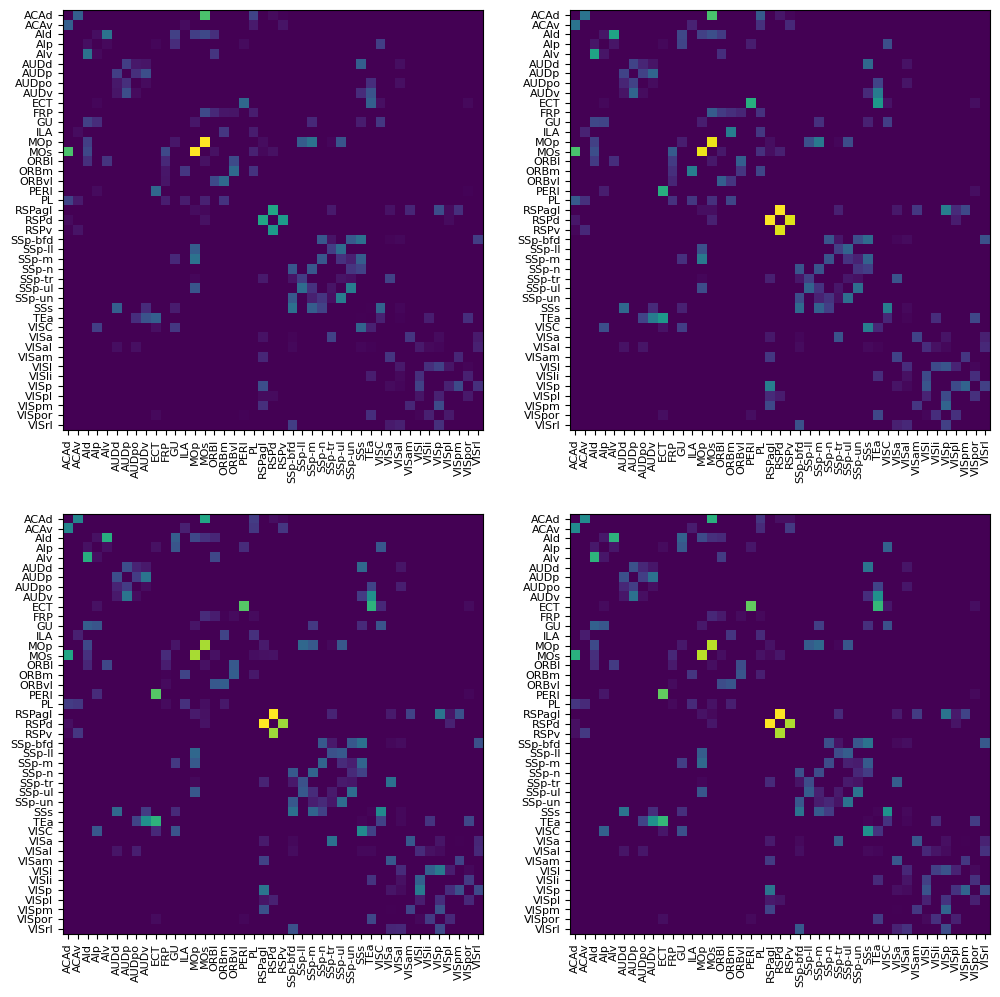

In [27]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(2, 2, 1)
ax.imshow(border_3d)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")

ax = fig.add_subplot(2, 2, 2)
ax.imshow(border_2d_aibs)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")

ax = fig.add_subplot(2, 2, 3)
ax.imshow(border_2d_square)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")

ax = fig.add_subplot(2, 2, 4)
ax.imshow(border_2d_shaped)
ax.set_yticks(range(len(tgt_ids)))
_ = ax.set_yticklabels(tgt_acronyms, fontsize=8)
ax.set_xticks(range(len(tgt_ids)))
_ = ax.set_xticklabels(tgt_acronyms, fontsize=8, rotation="vertical")


array([1.        , 0.95481112, 0.93646209, 0.93998698])

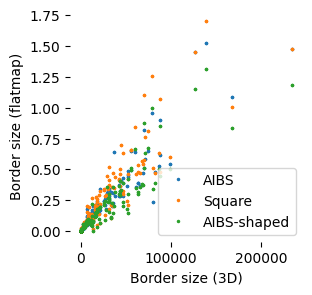

In [35]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

# account for pixel size difference by scaling by number of pixels
ax.plot(border_3d.values.flatten(), border_2d_aibs.values.flatten() / npix_aibs, '.', ms=3, label=labels[0])
ax.plot(border_3d.values.flatten(), border_2d_square.values.flatten() / npix_flat, '.', ms=3, label=labels[1])
ax.plot(border_3d.values.flatten(), border_2d_shaped.values.flatten() / npix_flat, '.', ms=3, label=labels[2])

ax.set_xlabel("Border size (3D)")
ax.set_ylabel("Border size (flatmap)")
ax.set_frame_on(False)

plt.legend()

fig.savefig("comparing_border_sizes.pdf")

numpy.corrcoef([border_3d.values.flatten(),
               border_2d_aibs.values.flatten(),
               border_2d_square.values.flatten(),
               border_2d_shaped.values.flatten()])[0]

### Uniformity of voxels per pixel

The true size of regions is likely to be represented correctly if the number of voxels mapping to a pixel is somewhat uniform.
It is expected to vary slightly, due to variability of cortical thickness.

In [78]:
vox_per_pxl_aibs = pd_fm_aibs.groupby(["pxl_x", "pxl_y"])["idx"].count()
vox_per_pxl_square = pd_fm_square.groupby(["pxl_x", "pxl_y"])["idx"].count()
vox_per_pxl_shaped = pd_fm_shaped.groupby(["pxl_x", "pxl_y"])["idx"].count()

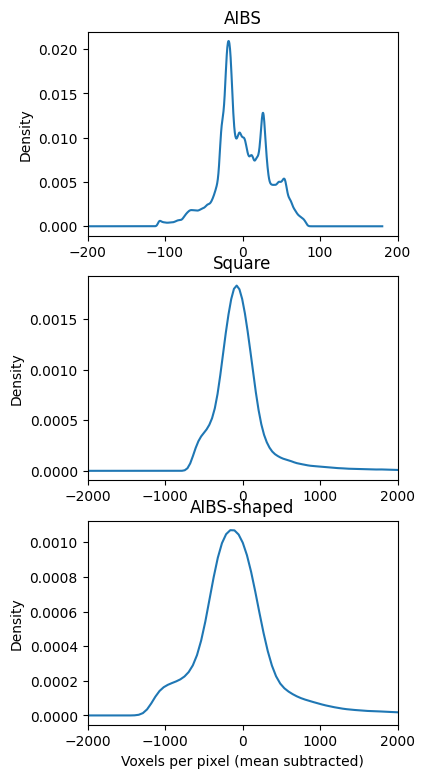

In [88]:
vox_per_pxl_aibs_n = vox_per_pxl_aibs - vox_per_pxl_aibs.mean()
vox_per_pxl_square_n = vox_per_pxl_square - vox_per_pxl_square.mean()
vox_per_pxl_shaped_n = vox_per_pxl_shaped - vox_per_pxl_shaped.mean()

fig = plt.figure(figsize=(4, 9))

ax = fig.add_subplot(3, 1, 1)
ax.set_xlim(-200,200)
ax.set_title(labels[0])
vox_per_pxl_aibs_n.plot.density(ax=ax)

ax = fig.add_subplot(3, 1, 2)
ax.set_xlim(-2000,2000)
ax.set_title(labels[1])
vox_per_pxl_square_n.plot.density(ax=ax)

ax = fig.add_subplot(3, 1, 3)
ax.set_xlim(-2000,2000)
ax.set_title(labels[2])
vox_per_pxl_shaped_n.plot.density(ax=ax)

plt.gca().set_xlabel("Voxels per pixel (mean subtracted)")

fig.savefig("comparing_voxels_per_pixel_10um.pdf")

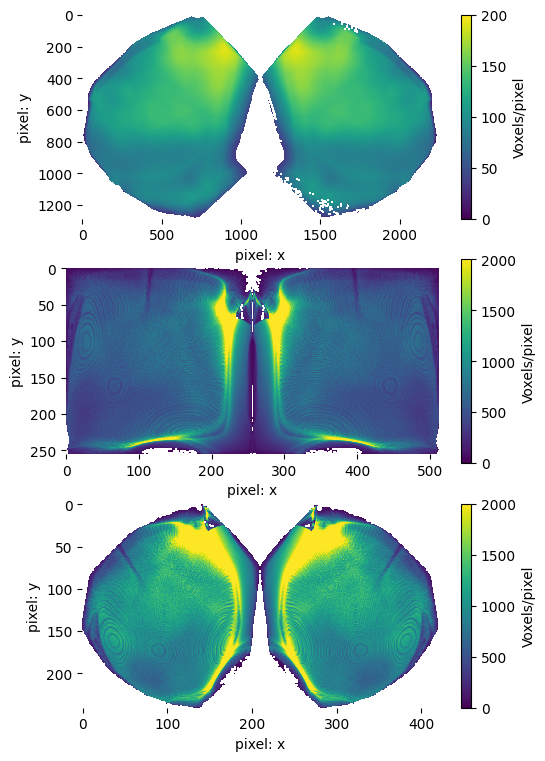

In [93]:
fig = plt.figure(figsize=(6, 9))

ax = fig.add_subplot(3, 1, 1)
plt.colorbar(ax.imshow(vox_per_pxl_aibs.unstack("pxl_y"), clim=[0,200]),
             label="Voxels/pixel")
ax.set_frame_on(False)
ax.set_xlabel("pixel: x"); ax.set_ylabel("pixel: y")

ax = fig.add_subplot(3, 1, 2)
plt.colorbar(ax.imshow(vox_per_pxl_square.unstack("pxl_y"), clim=[0, 2000]),
             label="Voxels/pixel")
ax.set_frame_on(False)
ax.set_xlabel("pixel: x"); ax.set_ylabel("pixel: y")

ax = fig.add_subplot(3, 1, 3)
plt.colorbar(ax.imshow(vox_per_pxl_shaped.unstack("pxl_y"), clim=[0, 2000]),
             label="Voxels/pixel")
ax.set_frame_on(False)
ax.set_xlabel("pixel: x"); ax.set_ylabel("pixel: y")

fig.savefig("comparing_voxels_per_pixel_image_10um.pdf")

## How well are the relative orientations of regions towards each other captured?

We would like regions that are aligned along a given axis of the brain to also show up along a line in the flat view.

To that end, we consider the orientations of pairs of regions to each other in the flat view. Specifically, we represent each region by its center (i.e. its average "pxl_x", "pxl_y" value). Then we consider as the orientation of the pair of regions to each other: the angle between the line connecting their centers and the vertical.

We compare this to the primitive flatmap that one gets by stripping away the "y" coordinate. That primitive flatmap should provide a robust idea of the actual orientation. 

All of this simplifies many aspects, but should provide a heurisitcal view of how well relative orientations are represented.

In [97]:
def calculate_pairwise_orientations(pd_fm, cols, tgt_ids):
    # Centers are simply the average coordinate values
    centers = pd_fm.groupby("ann")[cols].mean().loc[tgt_ids]
    
    # All pairwise offsets between centers
    d_center = centers.values.reshape((-1, 1, 2)) - centers.values.reshape((1, -1, 2))
    
    # Calculate angles using arctan2
    angles = numpy.arctan2(d_center[:, :, 0], d_center[:, :, 1]).flatten()
    
    return angles

# Results will be between -pi and pi. However, since the angle representations is cyclic,
# an angle x + 2 pi is the same as x. We add / subtract 2 pi where it provides a better fit
def correct_2pi_offset(df_in, col_fix, col_ref):
    mask_add_2pi = df_in[col_fix] - df_in[col_ref] < -numpy.pi
    mask_sub_2pi = df_in[col_fix] - df_in[col_ref] > numpy.pi
    df_in.loc[mask_add_2pi, col_fix] += 2 * numpy.pi
    df_in.loc[mask_sub_2pi, col_fix] -= 2 * numpy.pi

centerline = int(ann.raw.shape[2]/2) # For this analysis we only consider the right hemisphere

mask = (pd_fm_aibs["z"] >= centerline)
angles_fm_aibs = pandas.DataFrame({
    "flatmap": calculate_pairwise_orientations(pd_fm_aibs[mask], ["pxl_x", "pxl_y"], tgt_ids),
    "3d": calculate_pairwise_orientations(pd_fm_aibs[mask], ["x", "z"], tgt_ids)
})
correct_2pi_offset(angles_fm_aibs, "flatmap", "3d")

mask = (pd_fm_square["z"] >= centerline)
angles_fm_square = pandas.DataFrame({
    "flatmap": calculate_pairwise_orientations(pd_fm_square[mask], ["pxl_x", "pxl_y"], tgt_ids),
    "3d": calculate_pairwise_orientations(pd_fm_square[mask], ["x", "z"], tgt_ids)
})
correct_2pi_offset(angles_fm_square, "flatmap", "3d")

mask = (pd_fm_shaped["z"] >= centerline)
angles_fm_shaped = pandas.DataFrame({
    "flatmap": calculate_pairwise_orientations(pd_fm_shaped[mask], ["pxl_x", "pxl_y"], tgt_ids),
    "3d": calculate_pairwise_orientations(pd_fm_shaped[mask], ["x", "z"], tgt_ids)
})
correct_2pi_offset(angles_fm_shaped, "flatmap", "3d")

# A global rotation of the flatmap will show up as a constant offset of all angles.
# Such a global rotation is no big deal and is not what we want to consider an error.
# Thus, we calculate an optimal offset for the "flatmap" angles and calculate the error taking the offset into account.
global_rotation_aibs = angles_fm_aibs.diff(axis=1)["3d"].mean()
err_aibs = numpy.abs(angles_fm_aibs["flatmap"] - angles_fm_aibs["3d"] + global_rotation_aibs)

global_rotation_square = angles_fm_square.diff(axis=1)["3d"].mean()
err_square = numpy.abs(angles_fm_square["flatmap"] - angles_fm_square["3d"] + global_rotation_square)

global_rotation_shaped = angles_fm_shaped.diff(axis=1)["3d"].mean()
err_shaped = numpy.abs(angles_fm_shaped["flatmap"] - angles_fm_shaped["3d"] + global_rotation_shaped)

0.20764547471626427 0.2372449402848558 0.19144532333918055


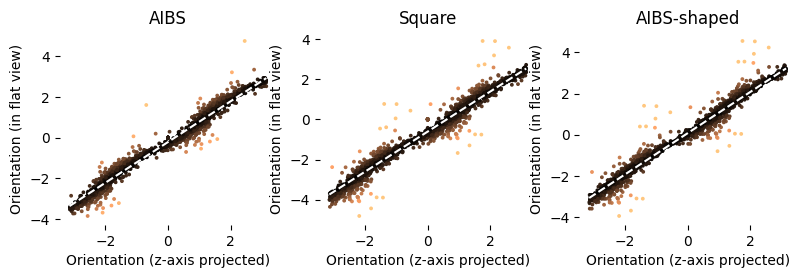

In [98]:
fig = plt.figure(figsize=(9.5, 2.5))
ax = fig.add_subplot(1, 3, 1)

ax.scatter(angles_fm_aibs["3d"], angles_fm_aibs["flatmap"], 3, err_aibs, clim=[0, numpy.pi / 2], cmap="copper")
# As visual reference we indicate a perfect fit (identity).
# It also takes the global rotation (offset) into account
ax.plot([-numpy.pi, numpy.pi], [-numpy.pi, numpy.pi] - global_rotation_aibs,
        color="white", ls="--")
ax.set_title(labels[0])
ax.set_xlabel("Orientation (z-axis projected)")
ax.set_ylabel("Orientation (in flat view)")
ax.set_frame_on(False)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(angles_fm_square["3d"], angles_fm_square["flatmap"], 3, err_square, clim=[0, numpy.pi / 2], cmap="copper")
# As visual reference we indicate a perfect fit (identity).
# It also takes the global rotation (offset) into account
ax.plot([-numpy.pi, numpy.pi], [-numpy.pi, numpy.pi] - global_rotation_square,
        color="white", ls="--")
ax.set_title(labels[1])
ax.set_xlabel("Orientation (z-axis projected)")
ax.set_ylabel("Orientation (in flat view)")
ax.set_frame_on(False)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(angles_fm_shaped["3d"], angles_fm_shaped["flatmap"], 3, err_shaped, clim=[0, numpy.pi / 2], cmap="copper")
# As visual reference we indicate a perfect fit (identity).
# It also takes the global rotation (offset) into account
ax.plot([-numpy.pi, numpy.pi], [-numpy.pi, numpy.pi] - global_rotation_shaped,
        color="white", ls="--")
ax.set_title(labels[2])
ax.set_xlabel("Orientation (z-axis projected)")
ax.set_ylabel("Orientation (in flat view)")
ax.set_frame_on(False)

fig.savefig("comparing_representation_of_orientations.pdf")

print(err_aibs.mean(), err_square.mean(), err_shaped.mean())

## Use case: Volume decomposition.

In contrast to the AIBS flatmap, our method introduces an intentional constraint of having each voxel map to a single pixel.

This enables an important use case: Decomposition of the mapped volume into disjunct sub-volumes. 

We demonstrate this by attempting volume decomposition and then calculating how much neighboring sub-volumes overlap. We perform volume decomposition by first building a decomposition of the pixels, then taking their pre-images.

In [258]:
def digitize_uniform_bin_size(data_in, bin_sz):
    bins = numpy.arange(0, data_in.max() + bin_sz, bin_sz)
    return numpy.digitize(data_in, bins=bins) - 1

def discretize_pixels(pd_df, bin_sz):
    df = pandas.concat([
        pd_df[["pxl_x", "pxl_y"]].apply(lambda _x: digitize_uniform_bin_size(_x, bin_sz), axis=0),
        pd_df["idx"]
    ], axis=1)
    return df

def decompose_and_count_overlap(pd_df, overlap, bin_sz):
    decomposition = discretize_pixels(pd_df, bin_sz).groupby(["pxl_x", "pxl_y"])["idx"].apply(list)
    frac_non_unique = decomposition.apply(lambda x: [overlap[y] for y in x]).apply(numpy.mean)
    return frac_non_unique.unstack("pxl_y")

In [256]:
# Find whether voxels are used more than once
overlap_fm_aibs = {k:(v > 1) for k, v in pd_fm_aibs["idx"].value_counts().items()}
overlap_fm_square = {k:(v > 1) for k, v in pd_fm_square["idx"].value_counts().items()}
overlap_fm_shaped = {k:(v > 1) for k, v in pd_fm_shaped["idx"].value_counts().items()}

In [259]:
# We decompose the volume into pre-images corresponding to patches of N x N pixels in flat view
show_bin_sz = npix_aibs // npix_flat # This is the value of N. Adjust to try different values.

# Counts the fraction of voxels in the decomposition that are not unique to a given pre-image.
non_unique_aibs = decompose_and_count_overlap(pd_fm_aibs, overlap_fm_aibs, show_bin_sz)
non_unique_square = decompose_and_count_overlap(pd_fm_square, overlap_fm_square, 1)
non_unique_shaped = decompose_and_count_overlap(pd_fm_shaped, overlap_fm_shaped, 1)

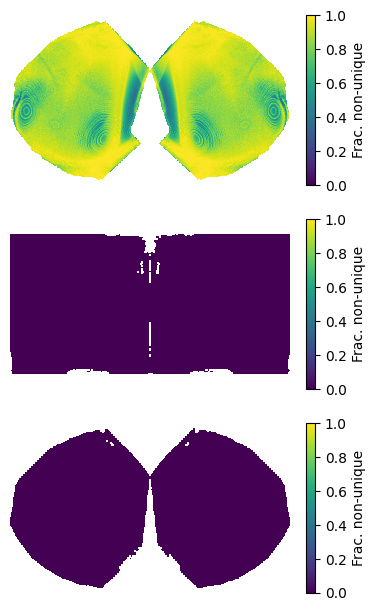

In [260]:
fig = plt.figure(figsize=(4.5, 7.5))

ax = fig.add_subplot(3, 1, 1)
plt.colorbar(ax.imshow(non_unique_aibs, clim=[0, 1]),
             label="Frac. non-unique")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(3, 1, 2)
plt.colorbar(ax.imshow(non_unique_square, clim=[0, 1]),
             label="Frac. non-unique")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(3, 1, 3)
plt.colorbar(ax.imshow(non_unique_shaped, clim=[0, 1]),
             label="Frac. non-unique")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

fig.savefig("comparing_frac_non_unique_voxels_{0}_pixels.pdf".format(show_bin_sz))

In [261]:
# For the AIBS flatmap: Try different sizes and plot mean +- std of non-unique voxels.
# THIS MAY TAKE A WHILE.
smpl_bin_szs = [1, 2, 5, 10, 15, 20, 25]

def mean_and_std(df_in):
    return pandas.Series([df_in.mean(axis=None), df_in.stack().std()],
                         index=["mean", "std"])

non_unique_series = [
    mean_and_std(decompose_and_count_overlap(pd_fm_aibs, overlap_fm_aibs, _bin_sz))
    for _bin_sz in smpl_bin_szs
]
non_unique_series = pandas.concat(non_unique_series, axis=0, keys=smpl_bin_szs).unstack(1)

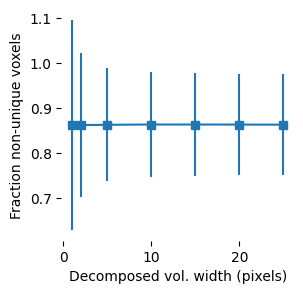

In [262]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

ax.errorbar(non_unique_series.index, non_unique_series["mean"],
            yerr=non_unique_series["std"], marker='s')
ax.set_frame_on(False)
ax.set_xlabel("Decomposed vol. width (pixels)")
ax.set_ylabel("Fraction non-unique voxels")

fig.savefig("frac_non_unique_voxels_various_sizes.pdf")

### Mean number of pixels per voxel

In [ ]:
def mean_number_of_pixels_per_voxel(pd_fm):
    multiplicity = pd_fm[["x", "y", "z"]].value_counts()
    multiplicity = multiplicity[pandas.MultiIndex.from_frame(pd_fm[["x", "y", "z"]])]
    multiplicity.index = pd_fm.index
    multiplicity.name = "multiplicity"
    multiplicity = pandas.concat([pd_fm, multiplicity], axis=1)
    I = multiplicity.groupby(["pxl_x", "pxl_y"])["multiplicity"].mean().unstack("pxl_y")
    return I

multipl_aibs = mean_number_of_pixels_per_voxel(pd_fm_aibs)
multipl_square = mean_number_of_pixels_per_voxel(pd_fm_square)
multipl_shaped = mean_number_of_pixels_per_voxel(pd_fm_shaped)

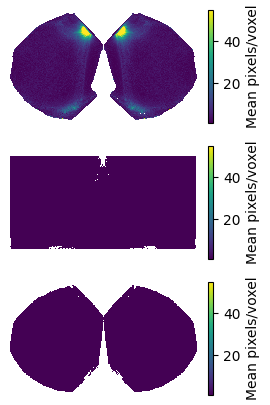

In [336]:
fig = plt.figure(figsize=(3, 5))

ax = fig.add_subplot(3, 1, 1)
plt.colorbar(ax.imshow(multipl_aibs, clim=[1, 55], interpolation='nearest'),
             label="Mean pixels/voxel")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(3, 1, 2)
plt.colorbar(ax.imshow(multipl_square, clim=[1, 55], interpolation='nearest'),
             label="Mean pixels/voxel")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(3, 1, 3)
plt.colorbar(ax.imshow(multipl_shaped, clim=[1, 55], interpolation='nearest'),
             label="Mean pixels/voxel")
ax.set_frame_on(False)
ax.set_xticks([]); ax.set_yticks([])

fig.savefig("comparing_pixels_per_voxel_image_10um.pdf")

### Alternative, more complex way of plotting coordinates of one flatmap in the other

In [263]:
pd_fm_1 = pd_fm_aibs
pd_fm_2 = pd_fm_shaped

In [264]:
a = pd_fm_1["pxl_x"] / pd_fm_1["pxl_x"].max()
b = pd_fm_1["pxl_y"] / pd_fm_1["pxl_y"].max()

cols = pandas.DataFrame({
    "r": a, "g": b, "b": 1.0 - 0.5 * a - 0.5 * b
})
pd_fm_1 = pandas.concat([pd_fm_1, cols], axis=1)

In [265]:
a = pd_fm_2["pxl_x"] / pd_fm_2["pxl_x"].max()
b = pd_fm_2["pxl_y"] / pd_fm_2["pxl_y"].max()

cols = pandas.DataFrame({
    "r": a, "g": b, "b": 1.0 - 0.5 * a - 0.5 * b
})
pd_fm_2 = pandas.concat([pd_fm_2, cols], axis=1)

In [267]:
def create_rgb_image(fm_use, fm_show):
    I = numpy.dstack([
        visualize_flatmap_in_other_flatmap(fm_use, fm_show, _prop).values
        for _prop in ["r", "g", "b"]])
    return I

In [282]:
im_1_1 = create_rgb_image(pd_fm_1, pd_fm_1)
im_2_1 = create_rgb_image(pd_fm_2, pd_fm_1)
im_2_2 = create_rgb_image(pd_fm_2, pd_fm_2)
im_1_2 = create_rgb_image(pd_fm_1, pd_fm_2)

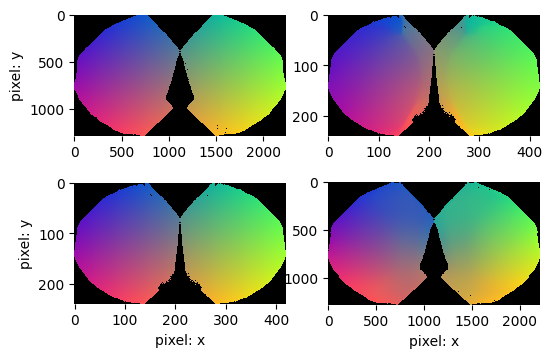

In [319]:
fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(2, 2, 1)
ax.imshow(numpy.nan_to_num(im_1_1), interpolation='nearest', vmax=1)
ax.set_ylabel("pixel: y")
ax.set_frame_on(False)
ax = fig.add_subplot(2, 2, 2)
ax.imshow(numpy.nan_to_num(im_2_1), interpolation='nearest', vmax=1)
ax.set_frame_on(False)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(numpy.nan_to_num(im_2_2), interpolation='nearest', vmax=1)
ax.set_ylabel("pixel: y")
ax.set_xlabel("pixel: x")
ax.set_frame_on(False)
ax = fig.add_subplot(2, 2, 4)
ax.imshow(numpy.nan_to_num(im_1_2), interpolation='nearest', vmax=1)
ax.set_xlabel("pixel: x")
ax.set_frame_on(False)

fig.savefig("comparing_flatmap_coordinates_colors_10um.pdf")

In [331]:
uvox = numpy.unique(pd_fm_square["idx"])
mask_aibs = numpy.zeros_like(ann.raw, dtype=numpy.uint8)
mask_aibs.flat[uvox] = 1
ann.with_data(mask_aibs).save_nrrd('mask_aibs.nrrd')